In [1]:
def get_labels(column):
    df = values.loc[values.columna == column, ['value', 'label']]
    return df.set_index('value').to_dict()['label']

def where(list_a,list_b,targets,if_false=None):
    import collections
    if type(list_a) != type(list_b):
        raise Exception('list_a y list_b son de tipos diferentes!')
    if not isinstance(targets, collections.Sequence) or isinstance(targets, str):
        targets = [targets]
    targets = set(targets)
    list_new = []
#     import pdb; pdb.set_trace()
    if isinstance(list_a, list):
        if len(list_a) != len(list_b):
            raise Exception('list_a y list_b tienen distinta longitud!')
        for i, value in enumerate(list_a):
            if value in targets:
                list_new.append(list_b[i])
            elif if_false is not None:
                list_new.append(if_false)
            else:
                pass
    return list_new

def juntar_intervenciones(row):
    if not row['sinModificaciones']:
        if 'si' in where(row['intervenciones.intervencion'], row['intervenciones.intervencionRealizacion'], 7):
            row['intervenciones.intervencion'] += [i + 100 for i in row['intervencionesOtras.intervencionOtra']]
            row['intervenciones.intervencionRealizacion'] += row['intervencionesOtras.intervencionOtraRealizacion']
            row['intervenciones.intervencionLugar'] += row['intervencionesOtras.intervencionOtraLugar']
            row['intervenciones.intervencionAno'] += row['intervencionesOtras.intervencionOtraAno']
    return row

In [2]:
%run parse.py

In [3]:
data = data_json.copy()

data = data.apply(juntar_intervenciones, axis=1)
data = data.drop(
    ['intervencionesOtras.intervencionOtra',
     'intervencionesOtras.intervencionOtraRealizacion',
     'intervencionesOtras.intervencionOtraLugar',
     'intervencionesOtras.intervencionOtraAno'],
    axis='columns'
)

In [4]:
%run values.py
values['value'] = values['value'].apply(str2int)

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

## Número de encuestas válidas:

In [54]:
len(data)

280

#### 1. % de personas expulsadas de su hogar según masculinidad /femenidades 
identidad == 3 (f) / 4,5 (m)  
identidad == 8 (otra) ?  
identidadSub == f/m  

emanciparMotivos == 1|2|5

In [6]:
expulsion = data['emanciparMotivos'].apply(lambda x: len(set([1,2,5]) & set(x)) > 0)
masculinidad = data['identidad'].isin([4,5]) | (data['identidadSub'] == 'm')
femenidad = data['identidad'].isin([3]) | (data['identidadSub'] == 'f')

print('porcentaje femenidades expulsadas')
print((femenidad & expulsion).sum() / femenidad.sum() * 100)
print()
print('porcentaje masculinidades expulsadas')
print((masculinidad & expulsion).sum() / masculinidad.sum() * 100)

porcentaje femenidades expulsadas
30.0

porcentaje masculinidades expulsadas
13.846153846153847


#### 2. Edad a la que fueron expulsadas del hogar según masculinidad o femeneidad
emanciparEdad, categórica

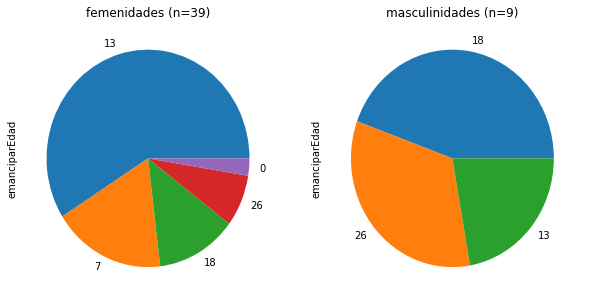

In [7]:
expulsadas_f = data[femenidad & expulsion].emanciparEdad#.replace(get_labels('emanciparEdad'))
expulsadas_m = data[masculinidad & expulsion].emanciparEdad#.replace(get_labels('emanciparEdad'))

_, axarr = plt.subplots(1, 2, figsize=(10,5))

expulsadas_f.value_counts(normalize=True).plot.pie(
    title='femenidades (n={})'.format(expulsadas_f.count()), ax=axarr[0])

expulsadas_m.value_counts(normalize=True).plot.pie(
    title='masculinidades (n={})'.format(expulsadas_m.count()), ax=axarr[1])


#### 3. Si fue expulsadx del hogar, sacar % del nivel de estudios alcanzado
maxEduca, categórica

No expulsadx refiere a total de encuestas EXCEPTO expulsadxs


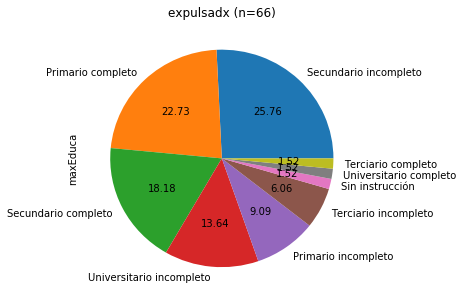

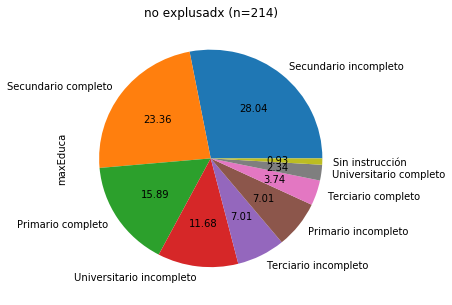

In [8]:
print('No expulsadx refiere a total de encuestas EXCEPTO expulsadxs')

# _, axarr = plt.subplots(1, 2, figsize=(10,5))

data[expulsion].maxEduca.replace(get_labels('maxEduca')).value_counts(normalize=True).plot.pie(
    title='expulsadx (n={})'.format(expulsion.sum()),
    autopct='%.2f',
    figsize=(5,5),
#     ax=axarr[0]
)
plt.show()

data[~expulsion].maxEduca.replace(get_labels('maxEduca')).value_counts(normalize=True).plot.pie(
    title='no explusadx (n={})'.format((~expulsion).sum()),
    autopct='%.2f',
    figsize=(5,5),
#     ax=axarr[1]
)
plt.show()

#### 4. % de encuestadxs que son el principal sosten del hogar y no viven solxs
len(integrantes.integrante) > 1
integrantes.aportante if integrantes.integrante == 1 (Encuestadx)

In [9]:
no_solxs = data['integrantes.integrante'].apply(lambda x: len(set(x)) > 1)
enc_ppal = data.apply(lambda x: 'principal' in where(x['integrantes.integrante'], x['integrantes.aportante'], 1), axis=1)

print('no viven solxs: {} ({:.2f}%)'.format(no_solxs.sum(), no_solxs.sum()/len(data)*100))
print('principal sostén y no viven solxs (% sobre no viven solxs): {} ({:.2f}%)'.format(
    (enc_ppal & no_solxs).sum(), (enc_ppal & no_solxs).sum()/no_solxs.sum()*100))
print('principal sostén y no viven solxs (% sobre total): {} ({:.2f}%)'.format(
    (enc_ppal & no_solxs).sum(), (enc_ppal & no_solxs).sum()/len(data)*100))

no viven solxs: 204 (72.86%)
principal sostén y no viven solxs (% sobre no viven solxs): 63 (30.88%)
principal sostén y no viven solxs (% sobre total): 63 (22.50%)


#### 5. # de personas que fueron expulsadas de su hogar y actualmente mantienen algún vínculo familiar
crianzaVinculos 1 | 2 | 4

In [10]:
vinculo = data['crianzaVinculos'].apply(lambda x: len(set([1,2,4]) & set(x)) > 0)
print('expulsadxs y mantienen vínculo (% sobre expulsadxs): {} ({:.2f})'.format(
    (expulsion & vinculo).sum(), (expulsion & vinculo).sum()/expulsion.sum()*100))
print('expulsadxs y mantienen vínculo (% total): {} ({:.2f})'.format(
    (expulsion & vinculo).sum(), (expulsion & vinculo).sum()/len(data)*100))

expulsadxs y mantienen vínculo (% sobre expulsadxs): 37 (56.06)
expulsadxs y mantienen vínculo (% total): 37 (13.21)


#### 6. % de personas mayores de 25 años ( 18 años al momento de la aprobación de la ley ) que actualmente están en búsqueda laboral
edad >= 25  
ingresosBusca == si

In [42]:
mas25 = data['edad'] >= 25
busqueda = data['ingresosBusca'] == 'si'
print('mayores 25: {} ({:.2f}%)'.format(
    mas25.sum(), mas25.sum()/len(data)*100))
print('mayor 25 y buscando trabajo (% sobre mayores 25): {} ({:.2f}%)'.format(
    (mas25 & busqueda).sum(), (mas25 & busqueda).sum()/mas25.sum()*100))
print('mayor 25 y buscando trabajo (% sobre total): {} ({:.2f}%)'.format(
    (mas25 & busqueda).sum(), (mas25 & busqueda).sum()/len(data)*100))

mayores 25: 211 (75.36%)
mayor 25 y buscando trabajo (% sobre mayores 25): 127 (60.19%)
mayor 25 y buscando trabajo (% sobre total): 127 (45.36%)


#### 7. de personas mayores de 40 años (inclusive) que perdieron algún trabjao por su identidad de género
edad >= 40  
ocupacionPerdio == si

In [12]:
mas40 = data['edad'] >= 40
perdida = data['ocupacionPerdio'] == 'si'
print('mayores 40: {} ({:.2f}%)'.format(
    mas40.sum(), mas40.sum()/len(data)))
print('mayor 40 y perdió trabajo (% sobre mayores 40): {} ({:.2f}%)'.format(
    (mas40 & perdida).sum(), (mas40 & perdida).sum()/mas40.sum()*100))
print('mayor 40 y perdió trabajo (% sobre total): {} ({:.2f}%)'.format(
    (mas40 & perdida).sum(), (mas40 & perdida).sum()/len(data)*100))

mayores 40: 83 (0.30%)
mayor 40 y perdió trabajo (% sobre mayores 40): 39 (46.99%)
mayor 40 y perdió trabajo (% sobre total): 39 (13.93%)


#### 8. # de personas mayores de 25 años y menor de 39 inclusive que perdieron algún trabjao por su identidad de génerp
40 > edad >= 25  
ocupacionPerdio == si

In [13]:
mas25 = data['edad'].isin(range(25,40))
print('entre 25 y 40: {} ({:.2f}%)'.format(
    mas25.sum(), mas25.sum()/len(data)))
print('entre 25 y 40 que perdió trabajo (% sobre de entre 25 y 40): {} ({:.2f}%)'.format(
    (mas25 & perdida).sum(), (mas25 & perdida).sum()/mas25.sum()*100))
print('entre 25 y 40 que perdió trabajo (% sobre total): {} ({:.2f}%)'.format(
    (mas25 & perdida).sum(), (mas25 & perdida).sum()/len(data)*100))

entre 25 y 40: 128 (0.46%)
entre 25 y 40 que perdió trabajo (% sobre de entre 25 y 40): 54 (42.19%)
entre 25 y 40 que perdió trabajo (% sobre total): 54 (19.29%)


#### 9. # de personas mayores de 16 años y menores de 24 inclusive que perdieron algún trabjao por su identidad de génerp
25 > edad >= 16  
ocupacionPerdio == si

In [14]:
mas16 = data['edad'].isin(range(16,25))
print('entre 16 y 25: {} ({:.2f}%)'.format(
    mas16.sum(), mas16.sum()/len(data)))
print('entre 16 y 25 que perdió trabajo (% sobre de entre 25 y 40): {} ({:.2f}%)'.format(
    (mas16 & perdida).sum(), (mas16 & perdida).sum()/mas16.sum()*100))
print('entre 16 y 25 que perdió trabajo (% sobre total): {} ({:.2f}%)'.format(
    (mas16 & perdida).sum(), (mas16 & perdida).sum()/len(data)*100))

entre 16 y 25: 69 (0.25%)
entre 16 y 25 que perdió trabajo (% sobre de entre 25 y 40): 16 (23.19%)
entre 16 y 25 que perdió trabajo (% sobre total): 16 (5.71%)


#### 10. # de personas que indican haber realizado algún curso de capacitación laboral y que dicen que no les sirvió para conseguir un empleo
politicasConoce == si  
cursoRealizo == si  
cursoSirvio == no

In [15]:
conoce = data['politicasConoce'] == 'si'
realizo = data['cursoRealizo'] == 'si'
no_sirvio = data['cursoSirvio'] == 'no'
print('conoce políticas y realizó cursos: {} ({:.2f}%)'.format(
    (conoce & realizo).sum(), (conoce & realizo).sum()/len(data)*100))
print('no sirvió curso (% sobre conoce y realizó): {} ({:.2f}%)'.format(
    no_sirvio.sum(), no_sirvio.sum()/(conoce & realizo).sum()*100))

conoce políticas y realizó cursos: 49 (17.50%)
no sirvió curso (% sobre conoce y realizó): 24 (48.98%)


#### 11. segun lugar de atención de salud que tipo de dificultades tuvieron
5.3	accesoDificultades, múltiple
5.1 consultaEspacios, múltiple

#### 12. salud preventiva. % de personas sobre el total
5.4 saludConsultas.4 | 5 | 6 | 10 | 11

In [16]:
prevencion = data.loc[:,
    ['saludConsultas.4', 'saludConsultas.5', 'saludConsultas.6', 'saludConsultas.10', 'saludConsultas.11']
].apply(lambda x: (x == 'si').any(), axis=1)
print('Salud preventiva: {} encuestadxs ({:.2f})'.format(
    prevencion.sum(), prevencion.sum()/len(data)*100))

Salud preventiva: 258 encuestadxs (92.14)


#### 13. % masculinidades mayores de 30 años que se hicieron examenes genitomamarios
edad >= 30  
saludConsultas.4

In [17]:
mas30_m = masculinidad & (data['edad'] >= 30)
genitom = data['saludConsultas.4'] == 'si'
print('Masculinidades mayores de 30 años: {} encuestadxs ({:2f}%)'.format(
    mas30_m.sum(), mas30_m.sum()/len(data)*100))
print('Exámenes genitomamarios sobre masculinidades mayores de 30: {:.2f}%'.format(
    (mas30_m & genitom).sum()/mas30_m.sum()*100))

Masculinidades mayores de 30 años: 22 encuestadxs (7.857143%)
Exámenes genitomamarios sobre masculinidades mayores de 30: 68.18%


#### 14. % femeneidades mayores de 30 años que se hicieron examenes de prostata
saludConsultas.5

In [18]:
mas30_f = femenidad & (data['edad'] >= 30)
prostata = data['saludConsultas.5'] == 'si'
print('Femenidades mayores de 30 años: {} encuestadxs ({:2f}%)'.format(
    mas30_f.sum(), mas30_f.sum()/len(data)*100))
print('Exámenes de próstata sobre femenidades mayores de 30: {:.2f}%'.format(
    (mas30_f & prostata).sum()/mas30_f.sum()*100))

Femenidades mayores de 30 años: 91 encuestadxs (32.500000%)
Exámenes de próstata sobre femenidades mayores de 30: 9.89%


#### 15. % que se realizó intervenciones en hospitales públicos antes y despues de la ley
intervenciones.intervencionLugar == 3 | intervencionesOtras.intervencionOtraLugar == 3  
intervenciones.intervencionAno, intervencionesOtras.intervencionOtraAno (2012)  

Se puede entender como porcentaje de encuestades que se realizó al menos una intervención en un hospital público, desagregado por año de realización (antes de 2012, después de 2012, y sin especificar el año).  
Como las personas podrían cambiar cuánto intervienen sus cuerpos en función del año, me parece mejor informar porcentaje de intervenciones (sobre total de intervenciones antes y después de 2012) que se realizaron en un hospital público.  
Primero, divido el dataset en dos (en ambos casos ignoro las intervenciones sin fecha de realización): por un lado, descarto las intervenciones realizadas en 2012 o después (pre2012); por otro lado descarto las intervenciones realizadas antes de 2012 (post2012).  
Luego, para cada dataset, calculo porcentaje de encuestadxs que realizaron intervenciones en hospital público, sobre el total de encuestadxs que realizaron algún tipo de intervención.

In [19]:
def binarizar(valor, umbral, cat_menor, cat_mayor):
    def valor2cat(elemento):
        try:
            elemento = int(elemento)
            if elemento != 99:
                elemento = cat_menor if elemento < umbral else cat_mayor
        except:
            pass
        return elemento

    if isinstance(valor, list):
        valor_new = []
        for elemento in valor:
            valor_new.append(valor2cat(elemento))
    else:
        valor_new = valor2cat(valor)
    return valor_new

data['intervenciones.intervencionAno'] = data['intervenciones.intervencionAno'].apply(
    lambda x: binarizar(x, 2012, 'pre2012', 'post2012')
)

data_pre = data.copy()
data_post = data.copy()
for columna in ['intervenciones.intervencion' + sufijo for sufijo in ['', 'Realizacion', 'Lugar', 'Ano']]:
    data_pre[columna] = data_pre.apply(
        lambda x: where(x['intervenciones.intervencionAno'], x[columna], 'pre2012'), axis=1
    )
    data_post[columna] = data_post.apply(
        lambda x: where(x['intervenciones.intervencionAno'], x[columna], 'post2012'), axis=1
    )

intervencion_pre = data_pre['intervenciones.intervencionLugar'].apply(lambda x: len(x) > 0 if isinstance(x, list) else False)
intervencion_post = data_post['intervenciones.intervencionLugar'].apply(lambda x: len(x) > 0 if isinstance(x, list) else False)
publico_pre = data_pre.loc[intervencion_pre, 'intervenciones.intervencionLugar'].apply(lambda x: 1 in x)
publico_post = data_post.loc[intervencion_post, 'intervenciones.intervencionLugar'].apply(lambda x: 1 in x)

print('Encuestades con intervenciones pre 2012: {} ({:.2f}%)'.format(
    intervencion_pre.sum(), intervencion_pre.sum()/len(data)*100)
)
print('Encuestades con intervenciones post 2012: {} ({:.2f}%)'.format(
    intervencion_post.sum(), intervencion_post.sum()/len(data)*100)
)

print(
    'Encuestades con intervenciones en hospital público pre 2012 (% sobre encuestades con intervenciones pre 2012): \
    {} ({:.2f}%)'.format(publico_pre.sum(), publico_pre.sum()/intervencion_pre.sum()*100)
)
print(
    'Encuestades con intervenciones en hospital público post 2012 (% sobre encuestades con intervenciones post 2012): \
    {} ({:.2f}%)'.format(publico_post.sum(), publico_post.sum()/intervencion_post.sum()*100)
)

Encuestades con intervenciones pre 2012: 69 (24.64%)
Encuestades con intervenciones post 2012: 116 (41.43%)
Encuestades con intervenciones en hospital público pre 2012 (% sobre encuestades con intervenciones pre 2012):     20 (28.99%)
Encuestades con intervenciones en hospital público post 2012 (% sobre encuestades con intervenciones post 2012):     38 (32.76%)


#### 16. # de personas que se hicieron intervenciones en domicilio particulares posterior a la ley (2012)
intervenciones.intervencionLugar == 2

In [20]:
domicilio_post = data_post.loc[intervencion_post, 'intervenciones.intervencionLugar'].apply(lambda x: 2 in x)
print(
    'Encuestades con intervenciones domiciliarias post 2012 (% sobre intervenciones post 2012): ' +
    '{} ({:.2f}%)'.format(domicilio_post.sum(), domicilio_post.sum()/intervencion_post.sum()*100)
)

Encuestades con intervenciones domiciliarias post 2012 (% sobre intervenciones post 2012): 11 (9.48%)


#### 17. % femeneidades que se inyectaron siliconas en domiclio particilar posterior al 2012
intervenciones.intervencion == 1

In [21]:
siliconas_post = data_post.loc[intervencion_post, 'intervenciones.intervencion'].apply(lambda x: 1 in x)
print(
    'Encuestades con inyección de siliconas en domicilio post 2012 (% sobre total femenidades): ' +
    '{} ({:.2f}%)'.format(
        (siliconas_post & domicilio_post & femenidad).sum(),
        (siliconas_post & domicilio_post & femenidad).sum() / femenidad.sum() * 100
    )
)

Encuestades con inyección de siliconas en domicilio post 2012 (% sobre total femenidades): 6 (4.62%)


#### 18-19. % de femeneidades que se inyectaron siliconas y SALIERON DE SUS CASAS  antes/después de los 18 años
Interpreto que se busca comparar el porcentaje de femenidades con inyección de siliconas según hayan salido de sus casas (i) antes, o (ii) después de los 18 años.

In [22]:
siliconas = data.apply(
    lambda x: 1 in where(x['intervenciones.intervencionRealizacion'], x['intervenciones.intervencion'], 'si'),
    axis=1
)
emancipacion = data['emanciparEdad'] != 'No corresponde'
emancipacion_pre18 = data['emanciparEdad'].isin([0,7,13])
emancipacion_post18 = data['emanciparEdad'].isin([18,26,35])
print(
    'Femenidades que salieron de sus casas antes de los 18 (% sobre total femenidades): ' +
    '{} ({:.2f}%)'.format(
        (femenidad & emancipacion_pre18).sum(),
        (femenidad & emancipacion_pre18).sum()/femenidad.sum()*100
    )
)
print(
    'Femenidades que salieron de sus casas después de los 18 (% sobre total femenidades): ' +
    '{} ({:.2f}%)'.format(
        (femenidad & emancipacion_post18).sum(),
        (femenidad & emancipacion_post18).sum()/femenidad.sum()*100
    )
)

print(
    'Inyección de siliconas (% sobre femenidades que salieron antes de los 18): ' +
    '{} ({:.2f}%)'.format(
        (siliconas & emancipacion_pre18 & femenidad).sum(),
        (siliconas & emancipacion_pre18 & femenidad).sum()/(emancipacion_pre18 & femenidad).sum()*100
    )
)
print(
    'Inyección de siliconas (% sobre femenidades que salieron después de los 18): ' +
    '{} ({:.2f}%)'.format(
        (siliconas & emancipacion_post18 & femenidad).sum(),
        (siliconas & emancipacion_post18 & femenidad).sum()/(emancipacion_post18 & femenidad).sum()*100
    )
)

Femenidades que salieron de sus casas antes de los 18 (% sobre total femenidades): 49 (37.69%)
Femenidades que salieron de sus casas después de los 18 (% sobre total femenidades): 34 (26.15%)
Inyección de siliconas (% sobre femenidades que salieron antes de los 18): 30 (61.22%)
Inyección de siliconas (% sobre femenidades que salieron después de los 18): 13 (38.24%)


#### 20. % de femeneidades/travestis que fueron expulsadas de su entorno de origen y ejercen prostitucion/trabajo sexual
femenidad | identidad == 1  
emanciparMotivos in [1, 2, 5, 6]  
remuneradas.remuneradaNombre == 15 | 51

In [23]:
entorno_expulsivo = data['emanciparMotivos'].apply(lambda x: len(set([1,2,5,6]) & set(x)) > 0)
travesti = data['identidad'] == 1
prostitucion = data['remuneradas.remuneradaNombre'].apply(lambda x: len(set(x) & set([15, 51])) > 0)
print(
    'Femenidades/travestis expulsadas de su entorno de origen (% sobre total femenidades/travestis): ' +
    '{} ({:.2f}%)'.format(
        ((femenidad | travesti) & entorno_expulsivo).sum(),
        ((femenidad | travesti) & entorno_expulsivo).sum()/(femenidad | travesti).sum()*100,
    )
)
print(
    'Ejercen prostitución (% sobre total femenidades/travestis expulsadas): ' +
    '{} ({:.2f}%)'.format(
        (prostitucion & (femenidad | travesti) & entorno_expulsivo).sum(),
        (prostitucion & (femenidad | travesti) & entorno_expulsivo).sum()/((femenidad | travesti) & entorno_expulsivo).sum()*100,
    )
)
print(
    'Ejercen prostitución (% sobre total femenidades/travestis -expulsadas o no): ' +
    '{} ({:.2f}%)'.format(
        (prostitucion & (femenidad | travesti)).sum(),
        (prostitucion & (femenidad | travesti)).sum()/((femenidad | travesti)).sum()*100,
    )
)

Femenidades/travestis expulsadas de su entorno de origen (% sobre total femenidades/travestis): 46 (30.07%)
Ejercen prostitución (% sobre total femenidades/travestis expulsadas): 25 (54.35%)
Ejercen prostitución (% sobre total femenidades/travestis -expulsadas o no): 62 (40.52%)


#### 21. % femeneidades/travestis que ejercen prostitucion/trabajo sexual y se inyectaron siliconas

In [24]:
print('Femenidades/travestis que ejercen prostitución: {}'.format((prostitucion & (femenidad | travesti)).sum()))
print(
    'Inyección siliconas (% sobre femenidades/travestis que ejercen prostitución): ' +
    '{} ({:.2f}%)'.format(
        (siliconas & prostitucion & (femenidad | travesti)).sum(),
        (siliconas & prostitucion & (femenidad | travesti)).sum()/(prostitucion & (femenidad | travesti)).sum()*100
    )
)
print(
    'Inyección siliconas (% sobre femenidades/travestis -ejerzan o no prostitución): ' +
    '{} ({:.2f}%)'.format(
        (siliconas & (femenidad | travesti)).sum(),
        (siliconas & (femenidad | travesti)).sum()/(femenidad | travesti).sum()*100
    )
)

Femenidades/travestis que ejercen prostitución: 62
Inyección siliconas (% sobre femenidades/travestis que ejercen prostitución): 36 (58.06%)
Inyección siliconas (% sobre femenidades/travestis -ejerzan o no prostitución): 77 (50.33%)


#### 22. # de personas que dicen no haber experimentado situaciones de violencia pero luego en el desglose se contradicen
violenciaExperimento == no  
situacionesNunca == False

In [27]:
print(
    'Dicen no haber experimentado situaciones violentas: {}'.format(
        (data['violenciaExperimento'] == 'no').sum()
    )
)
print(
    'Se contradicen (% sobre dicen no haber experimentado situaciones violentas): {} ({:.2f}%)'.format(
        ((data['violenciaExperimento'] == 'no') & ~data['situacionesNunca']).sum(),
        ((data['violenciaExperimento'] == 'no') & ~data['situacionesNunca']).sum()/(data['violenciaExperimento'] == 'no').sum()*100,
    )
)

Dicen no haber experimentado situaciones violentas: 44
Se contradicen (% sobre dicen no haber experimentado situaciones violentas): 23 (52.27%)


#### 23. % de personas que hicieron la denuncia en determinados lugares y fueron mal atendidas
denunciaLugares == 2|3|4 (Comisaría|Comisaría de la Mujer|Fiscalía)  
denunciaAtencion == 3|4|5

In [39]:
denuncia_seleccion = data['denunciaLugares'].apply(lambda x: len(set([2,3,4]) & set(x)) > 0)
denuncia_resto = data['denunciaLugares'].apply(lambda x: len([lugar for lugar in x if lugar not in [2,3,4]]) > 0)
denuncia_solo_seleccion = denuncia_seleccion & ~denuncia_resto
print('Hizo denuncia en comisaría, comisaría de la mujer y/o fiscalía: {}'.format(denuncia_seleccion.sum()))
print('Hizo denuncia SÓLO en comisaría, comisaría de la mujer y/o fiscalía: {}'.format(denuncia_solo_seleccion.sum()))
mala_atencion = data['denunciaAtencion'].isin([3,4,5])
print(
    'Mal atendide (% sobre hizo denuncia en comisaría, etc): {} ({:.2f}%)'.format(
        (mala_atencion & denuncia_solo_seleccion).sum(),
        (mala_atencion & denuncia_solo_seleccion).sum()/denuncia_solo_seleccion.sum()*100
    )
)

Hizo denuncia en comisaría, comisaría de la mujer y/o fiscalía: 59
Hizo denuncia SÓLO en comisaría, comisaría de la mujer y/o fiscalía: 55
Mal atendide (% sobre hizo denuncia en comisaría, etc): 18 (32.73%)


#### 24. % de personas de 25 años y más que sufrieron abuso policial sobre el total
mas25  
policialActos.[1-10] == si

In [52]:
abuso_policial = data.apply(lambda x: 'si' in x[[col for col in data.columns if 'policialActos.' in col]].values, axis=1)
print('Personas de 25 años o más: {}'.format(mas25.sum()))
print(
    '25 años o más y abuso policial (% sobre 25 años o más): {} ({:.2f}%)'.format(
        (mas25 & abuso_policial).sum(),
        (mas25 & abuso_policial).sum()/mas25.sum()*100,
    )
)
print(
    '25 años o más y abuso policial (% sobre total encuestades): {} ({:.2f}%)'.format(
        (mas25 & abuso_policial).sum(),
        (mas25 & abuso_policial).sum()/len(data)*100,
    )
)

Personas de 25 años o más: 211
25 años o más y abuso policial (% sobre 25 años o más): 163 (77.25%)
25 años o más y abuso policial (% sobre total encuestades): 163 (58.21%)


#### 25. % de personas menores de 25 años que sufrieron abuso policial sobre el total
edad < 25, no es lo mismo que NOT edad >= 25 (porque algunes podrían no haber respondido)

In [53]:
menos25 = data['edad'] < 25
print('Personas menores de 25 años: {}'.format(menos25.sum()))
print(
    'Menores de 25 y abuso policial (% sobre meores de 25): {} ({:.2f}%)'.format(
        (menos25 & abuso_policial).sum(),
        (menos25 & abuso_policial).sum()/menos25.sum()*100,
    )
)
print(
    'Menores de 25 y abuso policial (% sobre total encuestades): {} ({:.2f}%)'.format(
        (menos25 & abuso_policial).sum(),
        (menos25 & abuso_policial).sum()/len(data)*100,
    )
)

Personas menores de 25 años: 69
Menores de 25 y abuso policial (% sobre meores de 25): 33 (47.83%)
Menores de 25 y abuso policial (% sobre total encuestades): 33 (11.79%)


#### 26. % de femeneidades que ejercen el trabajo sexual/ prostitución y hayan sufrido violencia con fuerzas de seguridad
